# Data Science in Telco: Data Cleansing

## Import Library dan Dataset

In [11]:
## import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50

## import dataset
df_load = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco.csv')

## Tampilkan jumlah baris dan kolom
print(df_load.shape)


## Tampilkan 5 data teratas
print(df_load.head(5))
##Jumlah ID yang unik
print(df_load.customerID.nunique())

(7113, 22)
   UpdatedAt   customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     202006  45759018157  Female              0     Yes         No     1.0   
1     202006  45557574145    Male              0      No         No    34.0   
2     202006  45366876421    Male              0      No         No     2.0   
3     202006  45779536532    Male              0      No         No    45.0   
4     202006  45923787906  Female              0      No         No     2.0   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport St

## Memfilter ID Number Pelanggan Format Tertentu
Mencari format ID Number (Phone Number) Pelanggan customerID yang benar, dengan kriteria:

- Panjang karakter adalah 11-12.
* Terdiri dari Angka Saja, tidak diperbolehkan ada karakter selain angka
- Diawali dengan angka 45 2 digit pertama.

In [12]:
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')
df_load = (df_load[df_load['valid_id'] == True]).drop('valid_id', axis = 1)
print('Hasil jumlah ID Customer yang terfilter adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang terfilter adalah 7006


## Memfilter Duplikasi ID Number Pelanggan
Memastikan bahwa tidak ada Id Number pelanggan yang duplikat. 
Biasanya duplikasi ID number ini tipenya:
- Duplikasi dikarenakan inserting melebihi satu kali dengan nilai yang sama tiap kolomnya
* Duplikasi dikarenakan inserting beda periode pengambilan data

In [6]:
# Drop Duplicate Rows
df_load.drop_duplicates()
# Drop duplicate ID sorted by Periode
df_load = df_load.sort_values('UpdatedAt', ascending=False).drop_duplicates(['customerID'])
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah 6993


## Kesimpulan
Validitas dari ID Number pelanggan sangat diperlukan untuk memastikan bahwa data yang kita ambil sudah benar. 
Berdasarkan hasil tersbut, terdapat perbedaan jumlah nomor ID dari data pertama kali di load sampai dengan hasil akhir. 
Jumlah row data ketika pertama kali di load ada sebanyak 7113 rows dan 22 coloumns dengan 7017 jumlah ID yang Unique.
Kemudian setelah di cek validitas dari ID pelanggan,
maka tersisa 6993 rows data

## Mengatasi Missing Values dengan Penghapusan Rows

Selanjutnya kita akan menghapus Rows dari data-data yang tidak terdeteksi apakah dia churn atau tidak. 
Di asumsikan data modeller hanya mau menerima data yang benar ada flag churn nya atau tidak.
Gunakan isnull() digunakan untuk mendeteksi missing values dan dropna() untuk menghapus data yang missing values

In [13]:


print('Total missing values data dari kolom Churn',df_load['Churn'].isnull().sum())

df_load.dropna(subset=['Churn'],inplace=True)

print('Total Rows dan kolom Data setelah dihapus data Missing Values adalah',df_load.shape)

Total missing values data dari kolom Churn 43
Total Rows dan kolom Data setelah dihapus data Missing Values adalah (6963, 22)


## Mengatasi Missing Values dengan Pengisian Nilai tertentu

Selain dengan mengapus rows dari data, menangani missing values bisa menggunakan nilai tertentu. Diasumsikan data modeller meminta pengisian missing values dengan kriteria berikut:
- Tenure pihak data modeller meminta setiap rows yang memiliki missing values untuk Lama berlangganan di isi dengan 11
* Variable yang bersifat numeric selain Tenure di isi dengan median dari masing-masing variable tersebut

In [14]:
print('Status Missing Values :',df_load.isnull().values.any())
print('\nJumlah Missing Values masing-masing kolom, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

# handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

# Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
    median = df_load[col_name].median()
    df_load[col_name].fillna(median, inplace=True)

print('\nJumlah Missing Values setelah di imputer datanya, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values : True

Jumlah Missing Values masing-masing kolom, adalah:
tenure              99
MonthlyCharges      26
TotalCharges        15
Churn                0
InternetService      0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
UpdatedAt            0
dtype: int64

Jumlah Missing Values setelah di imputer datanya, adalah:
Churn               0
TotalCharges        0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV

## Kesimpulan
Setelah kita analisis lebih lanjut, ternyata masih ada Missing Values dari data yang kita sudah validkan Id Number pelanggannya. Missing values terdapat pada kolom Churn, tenure, MonthlyCharges & TotalCharges. Setelah kita tangani dengan cara penghapusan rows dan pengisian rows dengan nilai tertentu, terbukti sudah tidak ada missing values lagi pada data, terbukti dari jumlah missing values masing-masing variable yang bernilai 0. Selanjutnya kita akan melakukan penanganan pencilan (Outlier)

## Mendeteksi adanya Outlier (Boxplot)
Mendeteksi Pencilan dari suatu Nilai (Outlier) salah satunya bisa melihat plot dari data tersebut menggunakan Box Plot. Boxplot merupakan ringkasan distribusi sampel yang disajikan secara grafis yang bisa menggambarkan bentuk distribusi data (skewness), ukuran tendensi sentral dan ukuran penyebaran (keragaman) data pengamatan.

Gunakan package matplotlib & seaborn untuk memvisualisasika data-data yang mau dilihat box plot nya. Fungsi describe() gunakan saat untuk melihat deskripsi datanya


Persebaran data sebelum ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6963.000000     6963.000000   6963.000000
mean     32.487721       65.787527   2305.743767
std      25.189958       50.447879   2578.873345
min       0.000000        0.000000     19.000000
25%       9.000000       36.450000    407.650000
50%      29.000000       70.450000   1400.700000
75%      55.000000       89.850000   3803.050000
max     500.000000     2311.000000  80000.000000


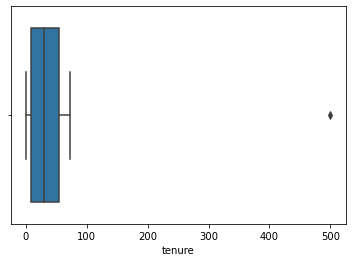

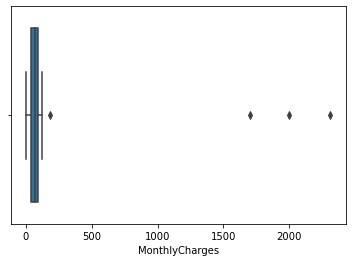

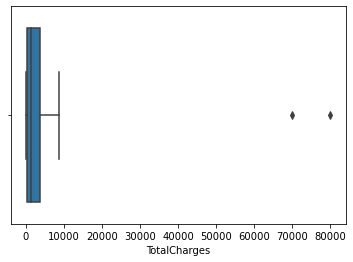

In [15]:
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

# Creating Box Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Masukkan variable
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['tenure'])
plt.show()

plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

## Mengatasi Outlier
Setelah kita mengetahui variable mana saja yang terdapat pencilan (Outlier),
selanjutnya kita akan atasi Outlier dengan menggunakan metode interquartile range (IQR). 
Untuk detil jelasnya, bisa dilihat di ilustrasi di bawah ini:
    
Gunakan hasil dari pengolahan di tahap sebelumnya df_load untuk di olah di tahap ini. 
Gunakan fungsi quantile() untuk melihat quantile tertentu, dan gunakan mask() untuk mereplace nilai. Tentukan:
- Nilai Minimum dan Maximum data di tolerir
* Ubah Nilai yg di luar Range Minumum & Maximum ke dalam nilai Minimum dan Maximum

In [16]:
# Handling with IQR
Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5 * IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)
minimum = Q1- (1.5 * IQR)
print('\nNilai Minimum dari masing-masing Variable adalah: ')
print(minimum)

more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)

print('\nPersebaran data setelah ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

Nilai Maximum dari masing-masing Variable adalah: 
tenure             124.00
MonthlyCharges     169.95
TotalCharges      8896.15
dtype: float64

Nilai Minimum dari masing-masing Variable adalah: 
tenure             -60.00
MonthlyCharges     -43.65
TotalCharges     -4685.45
dtype: float64

Persebaran data setelah ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6963.000000     6963.000000   6963.000000
mean     32.433721       64.996022   2286.756592
std      24.583319       30.061184   2266.591565
min       0.000000        0.000000     19.000000
25%       9.000000       36.450000    407.650000
50%      29.000000       70.450000   1400.700000
75%      55.000000       89.850000   3803.050000
max     124.000000      169.950000   8896.150000


## Kesimpulan
Dari ketiga boxplot dengan variable 'tenure','MonthlyCharges' & 'TotalCharges' terlihat jelas bahwasannya ada outlier. 
Hal ini bisa di identifikasi dari adanya titik titik yang berada jauh dari gambar boxplotnya. Kemudian kalo kita liat persebaran datanya dari kolom max nya juga ada nilai yang sangat tinggi sekali.

Kemudian nilai outlier tersebut ditangani dengan cara merubah nilainya ke nilai Maximum & Minimum dari interquartile range (IQR). Setelah di tangani outliernya, dan dilihat perseberan data nya, terlihat sudah tidak ada lagi nilai yang outlier.

## Mendeteksi Nilai yang tidak Standar
Mendeteksi apakah ada nilai-nilai dari variable kategorik yang tidak standard. Hal ini biasanya terjadi dikarenakan kesalahan input data. Perbedaan istilah menjadi salah satu faktor yang sering terjadi, untuk itu dibutuhkan standarisasi dari data yang sudah terinput.

Gunakan fungsi value_counts() untuk melihat jumlah data unique per variable nya

In [17]:
#Loop
# Masukkan variable
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
    print('\nUnique Values Count \033[1m' + 'Before Standardized \033[0m Variable',col_name)
    print(df_load[col_name].value_counts())


Unique Values Count Before Standardized  Variable gender
Male         3503
Female       3440
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values Count Before Standardized  Variable SeniorCitizen
0    5833
1    1130
Name: SeniorCitizen, dtype: int64

Unique Values Count Before Standardized  Variable Partner
No     3600
Yes    3363
Name: Partner, dtype: int64

Unique Values Count Before Standardized  Variable Dependents
No     4878
Yes    2065
Iya      20
Name: Dependents, dtype: int64

Unique Values Count Before Standardized  Variable PhoneService
Yes    6293
No      670
Name: PhoneService, dtype: int64

Unique Values Count Before Standardized  Variable MultipleLines
No                  3353
Yes                 2940
No phone service     670
Name: MultipleLines, dtype: int64

Unique Values Count Before Standardized  Variable InternetService
Fiber optic    3060
DSL            2394
No             1509
Name: InternetService, dtype: int64

Unique Values Count Befor

## Menstandarisasi Variable Kategorik
Setelah kita mengeteahui variable mana saja yang ada nilai tidak standar, 
maka kita standarkan dengan pola terbanyak nya, dengan syarat tanpa mengubah maknanya.
Contoh : Iya -> Yes Kemudian liat kembali unique values dari masing-masing variable yang sudah di ubah. 
Gunakan fungsi replace() untuk menstandarkan nilai

In [18]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],                                               ['Female','Male','Yes','Yes'])

# Masukkan variable
for col_name in list(['gender','Dependents','Churn']):
    print('\nUnique Values Count \033[1m' + 'After Standardized \033[0m Variable',col_name)
    print(df_load[col_name].value_counts())


Unique Values Count After Standardized  Variable gender
Male      3509
Female    3454
Name: gender, dtype: int64

Unique Values Count After Standardized  Variable Dependents
No     4878
Yes    2085
Name: Dependents, dtype: int64

Unique Values Count After Standardized  Variable Churn
No     5125
Yes    1838
Name: Churn, dtype: int64


## Kesimpulan
Ketika kita amati lebih jauh dari jumlah unique value dari masing-masing variable kategorik, terlihat jelas bahwa ada beberapa variable yang tidak standar. Variable itu adalah :

- Gender (Female, Male, Wanita, Laki-Laki), yang bisa di standarkan nilainya menjadi (Female, Male) karena mempunyai makna yang sama.
* Dependents (Yes, No, Iya), yang bisa di standarkan nilainya menjadi (Yes, No) karena mempunyai makna yang sama.
- Churn (Yes, No, Churn), yang bisa di standarkan nilainya menjadi (Yes, No) karena mempunyai makna yang sama.

Setelah kita standarkan nilainya, dan kita amati kembali bentuk datanya, sudah terstandar dengan baik untuk unique value nya.